# 2. Analyse ML avec Azure ML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

### Données Framingham

https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset

Attributes/columns:

- male: 0 = Female; 1 = Male
- age: Age at exam time
- education: 1 = Some High School; 2 = High School or GED; 3 = Some College or Vocational School; 4 = college
- currentSmoker: 0 = nonsmoker; 1 = smoker
- cigsPerDay: number of cigarettes smoked per day (estimated average)
- BPMeds: 0 = Not on Blood Pressure medications; 1 = Is on Blood Pressure medications
- prevalentStroke
- prevalentHyp
- diabetes: 0 = No; 1 = Yes
- totChol in mg/dL
- sysBP in mmHg
- diaBP in mmHg
- BMI: Body Mass Index calculated as: Weight (kg) / Height(meter-squared)
- heartRate: Beats/Min (Ventricular)
- glucose in mg/dL

- TenYearCHD - Did the person get heart disease in the 10 years study period?
label; 0 = No for heart disease, 1 = Yes for heart disease;


## 1. Informations

In [49]:
import azureml.core
print("Version Azure ML :", azureml.core.VERSION)

Version Azure ML : 1.19.0


## 2. Workspace Azure ML

In [50]:
subscription_id = "70b8f39e-8863-49f7-b6ba-34a80799550c" 
resource_group = "AMLworkshop-rg" 
workspace_name = "AMLworkshop" 
workspace_region = "westeurope" 

In [51]:
# Expérience Azure ML
experiment_name = 'Demo-AzureMachineLearning'

In [52]:
project_dir = './monprojet' #Répertoire stockage fichiers
model_name = 'TenYearCHD-model' #Nom du modèle ML
model_description = 'ML model to predict Ten Year CHD' # Description
cluster = "cpucluster" # Nom du cluster

In [53]:
import os
import logging

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.compute import ComputeTarget
from azureml.core.model import Model
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.core import Workspace
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

In [54]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True) #Leverage existing

ws.write_config()
print('Workspace configuration succeeded')

Workspace configuration succeeded


In [55]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: AMLworkshop
Azure region: westeurope
Resource group: AMLworkshop-rg


## 3. Expérimentation Azure ML

In [56]:
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

In [57]:
experiment = Experiment(ws, experiment_name)

## 4. Azure ML Compute

In [58]:
# Liste des compute servers disponibles
from azureml.core.compute import ComputeTarget, AmlCompute
AmlCompute.supported_vmsizes(workspace = ws)

[{'name': 'Standard_D1_v2',
  'vCPUs': 1,
  'gpus': 0,
  'memoryGB': 3.5,
  'maxResourceVolumeMB': 51200},
 {'name': 'Standard_D2_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 7.0,
  'maxResourceVolumeMB': 102400},
 {'name': 'Standard_D3_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 204800},
 {'name': 'Standard_D4_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 409600},
 {'name': 'Standard_D11_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 102400},
 {'name': 'Standard_D12_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 204800},
 {'name': 'Standard_D13_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 56.0,
  'maxResourceVolumeMB': 409600},
 {'name': 'Standard_D14_v2',
  'vCPUs': 16,
  'gpus': 0,
  'memoryGB': 112.0,
  'maxResourceVolumeMB': 819200},
 {'name': 'Standard_D15_v2',
  'vCPUs': 20,
  'gpus': 0,
  'memoryGB': 140.0,
  'maxResourceVolumeMB': 1024000},
 {'name': 'S

### Création Azure ML compute

In [59]:
%%time
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2', #Type VM
                                                           min_nodes=0, #Nombre noeuds min
                                                           max_nodes=4, #Nombre noeuds max
                                                           idle_seconds_before_scaledown=1200) #Time out scaling down

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster, compute_config)
    # Show output
    compute_target.wait_for_completion(show_output=True)

Creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
CPU times: user 121 ms, sys: 1.43 ms, total: 122 ms
Wall time: 21.2 s


### Liste des compute instances disponibles dans le workspace

In [60]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)

Compute Targets:
	 AzureDatabricks : Databricks
	 instanceaks : AKS
	 automl : AmlCompute
	 designer : AmlCompute
	 instancenbooks : ComputeInstance
	 cpucluster : AmlCompute


### Accès Azure ML Studio

In [61]:
experiment

Name,Workspace,Report Page,Docs Page
Demo-AzureMachineLearning,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


## 5. Environnement

In [62]:
# Docker based environment avec scikit-learn
training_venv = Environment("training_env")

training_venv.docker.enabled = True
training_venv.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn'])

### Génération fichier train.py

In [63]:
%%writefile $project_dir/train.py

   
import pandas as pd
import numpy as np
import pickle
import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

dataset_url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(dataset_url)

smoke = (df['currentSmoker']==1)
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())

df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

features = df.iloc[:,:-1]
result = df.iloc[:,-1] # the last column is what we are about to forecast

testsize=0.2
print("% test :", testsize)

# Train et Test
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = testsize, random_state = 14)

# RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train, y_train)

# Features selected
feat_labels = list(features.columns.values) # creating a list with features' names
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

# Feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking =")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# With only imporant features. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

# Calcul Accuracy
from sklearn import metrics
y_pred=clf.predict(X_test)
accuracy=metrics.accuracy_score(y_test, y_pred)
print("Accuracy du modèle :", accuracy)


# Export modèle
os.makedirs('./outputs/model', exist_ok=True)

filename = './outputs/model/chd-rf-model'
pickle.dump(clf_important, open(filename, 'wb'))
print("model saved in ././outputs/model/chd-rf-model folder")
print("Saving model completed")


Overwriting ./monprojet/train.py


In [64]:
!ls ./monprojet/train.py -l

-rwxrwxrwx 1 root root 2851 Jan  8 12:00 ./monprojet/train.py


In [65]:
!date

Fri Jan  8 12:00:53 UTC 2021


### Visualisation des données

In [66]:
import pandas as pd
url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(url)
df.head(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


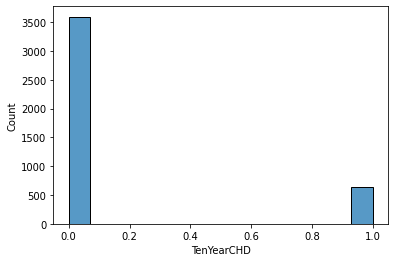

In [67]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.histplot(df['TenYearCHD'],kde = False)
plt.show()

## 6. Run

In [68]:
# Définition de tags pour le run
tagsdurun = {"Type" : "Test" , 
             "Langage" : "Python" , 
             "Framework" : "Scikit-Learn", 
             "Team" : "DataScience", 
             "Pays" : "France" }

In [69]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import DEFAULT_CPU_IMAGE

src = ScriptRunConfig(source_directory=project_dir, script='train.py')

# Compute Target
src.run_config.target = compute_target.name

# Set environment
src.run_config.environment = training_venv
 
run = experiment.submit(config=src, tags=tagsdurun)
run

Experiment,Id,Type,Status,Details Page,Docs Page
Demo-AzureMachineLearning,Demo-AzureMachineLearning_1610107254_53eb50e3,azureml.scriptrun,Queued,Link to Azure Machine Learning studio,Link to Documentation


### Widget pour suivre l'avancement du run

In [70]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Pour suivre l'avancement du run :

In [85]:
run.get_status()

'Completed'

In [86]:
run.get_environment

<bound method Run.get_environment of Run(Experiment: Demo-AzureMachineLearning,
Id: Demo-AzureMachineLearning_1610107254_53eb50e3,
Type: azureml.scriptrun,
Status: Completed)>

In [87]:
#run.get_details()

In [89]:
#get_status() gets the latest status of the AmlCompute target
compute_target.get_status().serialize()

{'currentNodeCount': 1,
 'targetNodeCount': 1,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 1,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-01-08T12:04:49.887000+00:00',
 'errors': None,
 'creationTime': '2021-01-08T12:00:31.628185+00:00',
 'modifiedTime': '2021-01-08T12:00:47.400120+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1200S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_D12_V2'}

## 7. Référencement du modèle avec Azure ML

In [90]:
if run.get_status() == 'Completed':
    print("Done.")
    print()
    model_run = run.register_model(model_name=model_name,  
                               model_path="././outputs/model/chd-rf-model",
                               tags={"Type": "ML Classification", 
                                     "Framework": "Scikit-Learn", 
                                     "IDE": "Jupyter Notebook",
                                     "Description": model_description, 
                                     "Run ID": run.id})
    
    print("Modèle ID :", model_run.id)
    print("Nom du modèle :", model_run.name)
    print("Version du modèle :", model_run.version)
    print("Date :", model_run.created_time)
    
else:
    print("OK")
    Exception("Erreur")

Done.

Modèle ID : TenYearCHD-model:2
Nom du modèle : TenYearCHD-model
Version du modèle : 2
Date : 2021-01-08 12:17:44.727250+00:00


## 8. Accès Azure ML Studio

In [91]:
experiment

Name,Workspace,Report Page,Docs Page
Demo-AzureMachineLearning,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


## 9. Suppression Azure ML compute instance

In [92]:
compute_target.delete()

Current provisioning state of AmlCompute is "Deleting"



> Fin